<a href="https://colab.research.google.com/github/jevabrir/Predicc_Millas_VS_galon_RedNeur_vs_RegMult/blob/main/Predicc_EficienciaAutos_RedNeu_VS_Reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Predicción del consumo de combustible (millas/galón) en Autos**

---
    

El objetivo de este proyecto es mostrar el procedimiento para diseñar dos modelos para estimar el **consumo de combustible en millas por galón mi/gal** utilizando la información del dataset auto-mpg.data.  

Los modelos que se diseñan e implementan en este script son:

*  **Redes neuronales**
*  **Regresión lineal múltiple**

Es importante mencionar que el objetivo del proyecto sólo es mostrar el procedimiento para diseñar y comparar los dos modelos, sin embargo, no se realizaron ajustes en ambos modelos para obtener las mejores estimaciones de cada uno.

## **1. Liberías**
#### Carga de algunas de las librerías utilizadas en el proyecto

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## **2.Creación del dataframe**  

Creación del dataframe a partir del conjunto de datos "auto-mpg". Este conjunto de datos contiene información sobre diversos aspectos de automóviles. Las columnas que tiene son las siguientes:  

*   **Mpg:** Millas por galón (consumo de combustible).
*   **Cylinders:** Número de cilindros.
*   **Displacement:** Desplazamiento del motor (pulgadas cúbicas).
*   **Horsepower:** Potencia (caballos de fuerza).
*   **Weight:** Peso del automóvil (libras).
*   **Acceleration:** Aceleración (tiempo que tarda en alcanzar los 60 mph desde el reposo, en segundos).
*   **Model year:** Año del modelo.
*   **Origin:** Origen del automóvil (1: USA, 2: Europa, 3: Japón).


In [2]:
# Descarga del archivo
dataset_path = tf.keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

  16384/Unknown 0s 9us/step

In [3]:
# Lista con nombres de las columnas del auto-mpg.dat
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',   'Acceleration', 'Model Year', 'Origin']

# Lee archivo auto-mpg.data como un csv utilizando las siguientes consideraciones
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?",        # cada valor "?" se establece como NaN
                      comment='\t',           # línea comenzando con '\t' (tabulación) será tratada como un comentario y, por lo tanto, será ignorada.
                      sep=" ",                # especifica valores separados por un espacio y no por ,
                      skipinitialspace=True)  # elimina los espacios en blanco adicionales que puedan aparecer después de los delimitadores.

df = raw_dataset.copy()     # Genera copia de raw_dataset

print("El tamaño del dataset es: ",df.shape)
df.head(3)                  # Imprime 3 primeras líneas del df

El tamaño del dataset es:  (398, 8)


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1


In [4]:
df.tail(3)                   # Imprime 3 últimas líneas del df

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [5]:
df.info()                    # Imprime información del df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


## **3.Análisis exploratorio**  

En esta parte se muestran los estadísticos del df con los datos cargados del archivo auto-mpg.data.

In [6]:
df.describe().transpose()       # Genera los estadísticos del df (muestra en forma transpuesta)

,count,mean,std,min,25%,50%,75%,max
MPG,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
Cylinders,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
Displacement,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
Horsepower,392.0,104.469388,38.491160,46.0,75.000,93.5,126.000,230.0
Weight,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
Acceleration,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
Model Year,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
Origin,398.0,1.572864,0.802055,1.0,1.000,1.0,2.000,3.0


El resumen de los estadísticos muestra las siguientes variables:

*   **Mpg:** var continua (9 a 46.6)
*   **Cylinders:** var discreta con valores múltiples (3,4,5,6,8)
*   **Displacement:**  var continua (68 a 455)
*   **Horsepower:** var continua (46 a 230)
*   **Weight:**  var continua (1613 a 5140)
*   **Acceleration:**  var continua (8 a 24.8)
*   **Model year:** var discreta con valores múltiples (70 a 82)
*   **Origin:** var vategórica (1: USA, 2: Europa, 3: Japón).

In [7]:
df["Cylinders"].unique()   # Imprime valores únicos de columna "Cylinders"

array([8, 4, 6, 3, 5])

Con el objetivo de conocer la distribución de las variables, se realiza la visualización de los datos para cada variable númerica mediante un histográma.

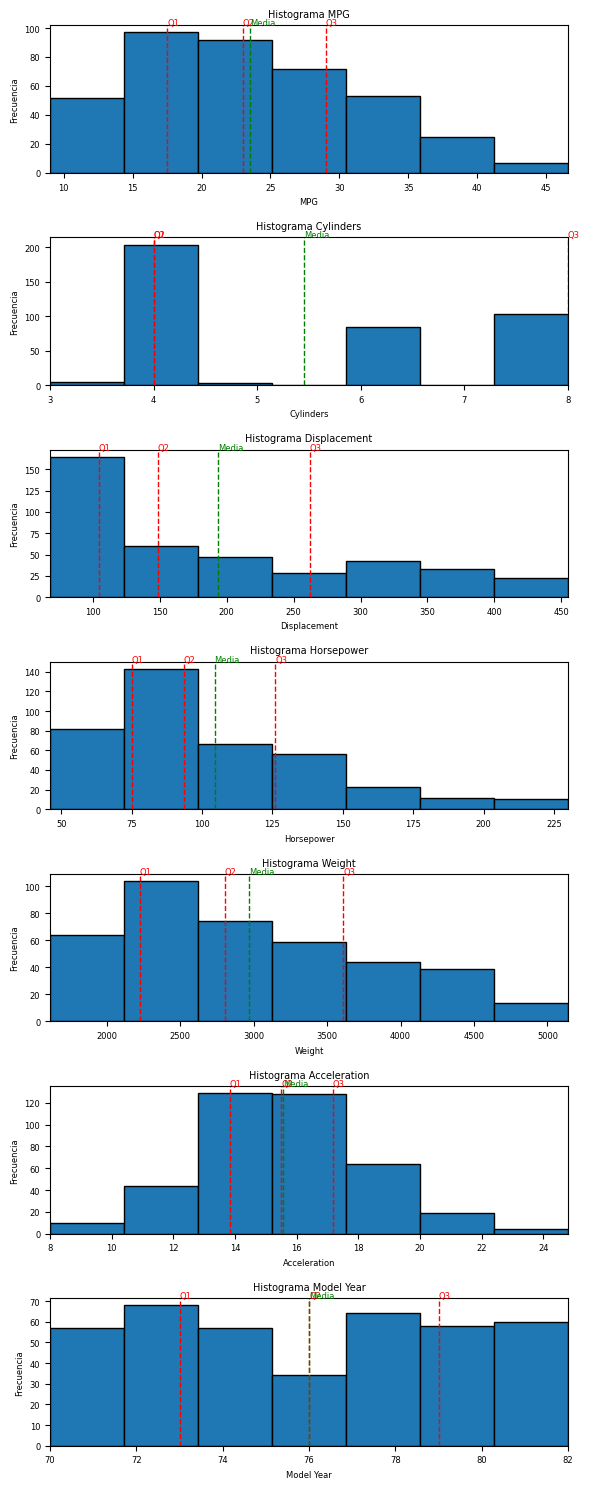

In [8]:
# Lista de variables numéricas
variables=['MPG','Cylinders','Displacement','Horsepower','Weight',   'Acceleration', 'Model Year']

# Genera una función para realizar un histograma
def plot_histograms(df, variables, tamX,tamY):

  num_his=len(variables)    # Número de variables = Número de histogramas
  dataset=df.copy()

  fig, axes = plt.subplots(nrows=num_his, ncols=1, figsize=(tamX, tamY))
  axis_label_size=6        # Tamaño de las etiquetas de los ejes
  x_tick_label_size=6      # Tamaño de las letras del eje x
  title_label_size = 7     # Tamaño del título

  numero = 7               # Define manualmente el num de intervalos

  for i, var in enumerate(variables):
      ax = axes[i]
      min_value = dataset[var].min()
      max_value = dataset[var].max()

     # Calcula los cuantiles
      Q1 = dataset[var].quantile(0.25)
      Q2 = dataset[var].quantile(0.50)
      Q3 = dataset[var].quantile(0.75)
      Qx = dataset[var].quantile(0.90)
      Med = dataset[var].mean()

      # Genera el histograma
      ax.hist(dataset[var], bins=numero, edgecolor='black')
      ax.set_xlim(min_value, max_value)
      ax.set_title(f'Histograma {var}', fontsize=title_label_size)
      ax.set_xlabel(var, fontsize=axis_label_size)
      ax.set_ylabel('Frecuencia', fontsize=axis_label_size)
      ax.axvline(Q1, color='r', linestyle='dashed', linewidth=1)
      ax.text(Q1, max(ax.get_ylim()) , 'Q1', color='r', fontsize=axis_label_size)
      ax.axvline(Q2, color='r', linestyle='dashed', linewidth=1)
      ax.text(Q2, max(ax.get_ylim()), 'Q2', color='r', fontsize=axis_label_size)
      ax.axvline(Q3, color='r', linestyle='dashed', linewidth=1)
      ax.text(Q3, max(ax.get_ylim()), 'Q3', color='r', fontsize=axis_label_size)
      ax.axvline(Med, color='g', linestyle='dashed', linewidth=1)
      ax.text(Med, max(ax.get_ylim()), 'Media', color='g', fontsize=axis_label_size)
      ax.tick_params(axis='x', labelsize=x_tick_label_size)   # Tamaño de las etiquetas de las marcas en el eje X
      ax.tick_params(axis='y', labelsize=x_tick_label_size)   # Tamaño de las etiquetas de las marcas en el eje Y

  # Ajusta el layout para evitar solapamientos
  plt.tight_layout()
  plt.show()

plot_histograms(df, variables,6,15)


In [9]:
print(df.isna().sum())     # Imprime suma de valores nulos de columnas

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


Con base en los resultados anteriores se puede observar que la columna "Horsepower" presenta 6 datos con valores nulos y para poder implementar los modelos de Predicción se requiere manejar estos valores núlos.

Se puede utilizar Pandas para manejar los valores faltantes del df, utilizando diferentes varios enfoques dependiendo de cómo se requiera manejar los valores faltantes (rellenarlos con la media, la mediana, la moda, o usar otros métodos).  

Para tratar los seis valores nuelos de la columna Horsepower se puede:  

*  Eliminar las 6 filas utilizando **df = df.dropna()**    
*  Imputar valores utilizando el valor de la media **df['Horsepower'] = df['Horsepower'].fillna(df['Horsepower'].dropna().mean())**  
*  Imputar valores utiliznado el valor de la moda de los datos

Otras formas de imputar valores son:
*  Imputar valores faltantes en la columna "ColumnaNumerica" con un valor constante (por ejemplo, 0)
df['ColumnaNumerica'].fillna(0, inplace=True)

*  Imputar valores faltantes en la columna "ColumnaCategorica" con un valor constante (por ejemplo, 'Desconocido')
df['ColumnaCategorica'].fillna('Desconocido', inplace=True)

Imputar Valores Faltantes de Todo el DataFrame:
*  df.fillna(df.mean(), inplace=True)

En este proyecto vamos a imputar valores faltantes con el valor de la media, pero primero realizamos un histograma de la variable Horsepower sin datos imputados y posteriormente se realiza el hitograma con los datos imputados y se observa que la distribución no cambia.

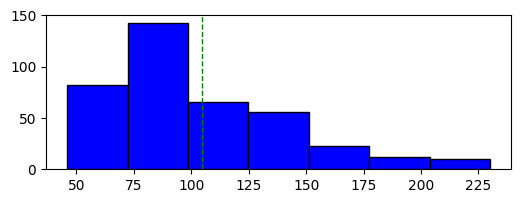

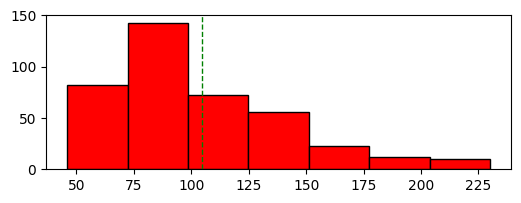

In [10]:
plt.figure(figsize=(6,2))           # Histográma datos sin imputar
plt.hist(df["Horsepower"], bins=7, color='blue', edgecolor='black')
plt.axvline(df["Horsepower"].mean(), color='g', linestyle='dashed', linewidth=1)
plt.show()

# Rellena los valores nulos empleando la media de los valores de 'Horsepower'
df['Horsepower'] = df['Horsepower'].fillna(df['Horsepower'].dropna().mean())

plt.figure(figsize=(6,2))    # Histográma datos con imputación media
plt.hist(df["Horsepower"], bins=7, color='red', edgecolor='black')
plt.axvline(df["Horsepower"].mean(), color='g', linestyle='dashed', linewidth=1)
plt.show()

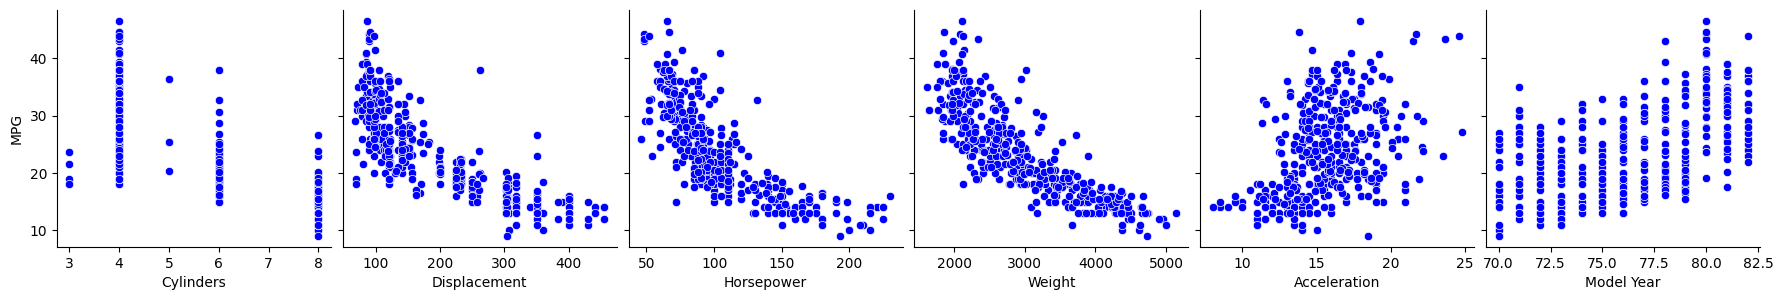

In [11]:
# Visualización de los datos
import seaborn as sns
import matplotlib.pyplot as plt

Var_Depen_X=['Cylinders','Displacement','Horsepower','Weight',   'Acceleration', 'Model Year']
Var_Indep_Y =['MPG']

g = sns.pairplot(df, x_vars=Var_Depen_X, y_vars=Var_Indep_Y, height=3, plot_kws={'color': 'blue'})

## **4. Modelos de predicción**  

En esta parte se generan los modelos para estimar el consumo de combustible en millas por galón mi/gal. Recordemos que el df tiene columnas con variables categóricas y numéricas, y para poder genera los modelos de machine learning se requiere que las variables categoricas se tranformen utilizando el método One Hot Encoding.

In [12]:
df.head(2)  # Muestra las 3 primeras columnas de df

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1


### **4.1 Transformación One Hot Encoding**  

La transformación One Hot Encoding es especialmente útil porque muchos algoritmos no pueden trabajar directamente con datos categóricos. En su lugar, convierten cada categoría en una nueva columna binaria (0 o 1).

In [13]:
# Aplica one-hot encoding a la columna 'Origin'
df_onehot = pd.get_dummies(df, columns=['Origin'], prefix='Origin', dtype=int)

# Muestra 5 filas elatorias del DataFrame
df_onehot.sample(5)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_1,Origin_2,Origin_3
161,16.0,6,250.0,105.0,3897.0,18.5,75,1,0,0
238,33.5,4,98.0,83.0,2075.0,15.9,77,1,0,0
27,11.0,8,318.0,210.0,4382.0,13.5,70,1,0,0
100,18.0,6,250.0,88.0,3021.0,16.5,73,1,0,0
182,28.0,4,107.0,86.0,2464.0,15.5,76,0,1,0


In [14]:
# Cambia nombres a las columnas
df_onehot = df_onehot.rename(columns={'Origin_1': 'USA', 'Origin_2': 'Europe', 'Origin_3': 'Japan'})
df_onehot.head(2)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,0,0


### **4.2 Datos entrenamiento y prueba**  

Los modelos de aprendizaje automático requieren dividir el conjunto de datos en conjuntos de entrenamiento y prueba. Esto permite evaluar el rendimiento del modelo de manera adecuada, asegurando que no se sobreajuste a los datos de entrenamiento. En esta etapa se requiere definir a las variables independientes y dependientes:

**y** = Variable a estimar, en este caso son las MGG (millas/galón)  
**x** = Varaibles de entrada, atributos o características a utilizar para estimar MPG y son Cylinders,	Displacement,	Horsepower,	Weight,	Acceleration,	Model Year,	USA,	Europe,	Japan,

In [15]:
from sklearn.model_selection import train_test_split

y = df_onehot["MPG"]                 # Variable de salida MPG (y=df_onehot.iloc[:, 0])
X = df_onehot.drop(columns="MPG")    # Variables de entrada (feaures)

# Separa en conjuntos de entrenamiento (80%) y prueba(20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mostrar las dimensiones de los conjuntos resultantes
print("Tamaño de X y y :", X.shape, y.shape)
print("Tamaño de X_train:", X_train.shape)
print("Tamaño de X_test:", X_test.shape)
print("Tamaño de y_train:", y_train.shape)
print("Tamaño de y_test:", y_test.shape)

Tamaño de X y y : (398, 9) (398,)
Tamaño de X_train: (318, 9)
Tamaño de X_test: (80, 9)
Tamaño de y_train: (318,)
Tamaño de y_test: (80,)


### **4.3 Normalización**  

La normalización es un proceso importante en la preparación de datos para modelos de aprendizaje automático. Consiste en ajustar las escalas de los diferentes atributos (características) para que contribuyan de manera equitativa al aprendizaje del modelo. Para realizar el proceso de normaización se puede utilizar sklearn.

from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()    
X_scaled = scaler.fit_transform(X)  
X_train_scaled = scaler.transform(X_train)  
X_test_scaled = scaler.transform(X_test)  

En este proyecto utilizaremos el siguiente código:

In [16]:
# Calcula estadisticos de features
X_Stats = X_train.describe().transpose()
X_Stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,318.0,5.430818,1.684947,3.0,4.00,4.0,6.00,8.0
Displacement,318.0,191.904088,102.983802,68.0,98.50,148.5,259.50,455.0
Horsepower,318.0,103.302978,37.065574,46.0,75.25,92.5,120.00,225.0
Weight,318.0,2969.015723,840.617729,1613.0,2220.00,2822.5,3597.25,5140.0
Acceleration,318.0,15.639937,2.763269,8.0,13.90,15.5,17.30,24.8
Model Year,318.0,76.103774,3.603177,70.0,73.00,76.0,79.00,82.0
USA,318.0,0.616352,0.487040,0.0,0.00,1.0,1.00,1.0
Europe,318.0,0.176101,0.381506,0.0,0.00,0.0,0.00,1.0
Japan,318.0,0.207547,0.406190,0.0,0.00,0.0,0.00,1.0


In [17]:
## Función para normalización con base en X_Stats
def normalization(x):
  return(x-X_Stats['mean'])/X_Stats['std']

X_scaled       = normalization(X)        # Normalización de X
X_train_scaled = normalization(X_train)  # Normalización de X_train
X_test_scaled  = normalization(X_test)   # Normalización de X_test

# Genera DataFrame con datos escalados. Utiliza los mismos nombres de columnas
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Concatena las variables y (target) y X (características) escaladas
#  en un solo DataFrame
df_scaled = pd.concat([y.reset_index(drop=True), X_scaled_df], axis=1)

pd.set_option('display.float_format', '{:.3f}'.format)  # Muestra 3 dec. en df

df_scaled.describe().transpose() # Muestra estadísticos del df escalado

#pd.reset_option('display.float_format')  # Elimina configuración 3 dec.

,count,mean,std,min,25%,50%,75%,max
MPG,398.000,23.515,7.816,9.000,17.500,23.000,29.000,46.600
Cylinders,398.000,0.014,1.010,-1.443,-0.849,-0.849,1.525,1.525
Displacement,398.000,0.015,1.012,-1.203,-0.851,-0.421,0.681,2.555
Horsepower,398.000,0.031,1.031,-1.546,-0.737,-0.224,0.585,3.418
Weight,398.000,0.002,1.007,-1.613,-0.887,-0.197,0.760,2.583
Acceleration,398.000,-0.026,0.998,-2.765,-0.657,-0.051,0.556,3.315
Model Year,398.000,-0.026,1.026,-1.694,-0.861,-0.029,0.804,1.636
USA,398.000,0.019,0.995,-1.266,-1.266,0.788,0.788,0.788
Europe,398.000,-0.001,0.999,-0.462,-0.462,-0.462,-0.462,2.160
Japan,398.000,-0.022,0.983,-0.511,-0.511,-0.511,-0.511,1.951


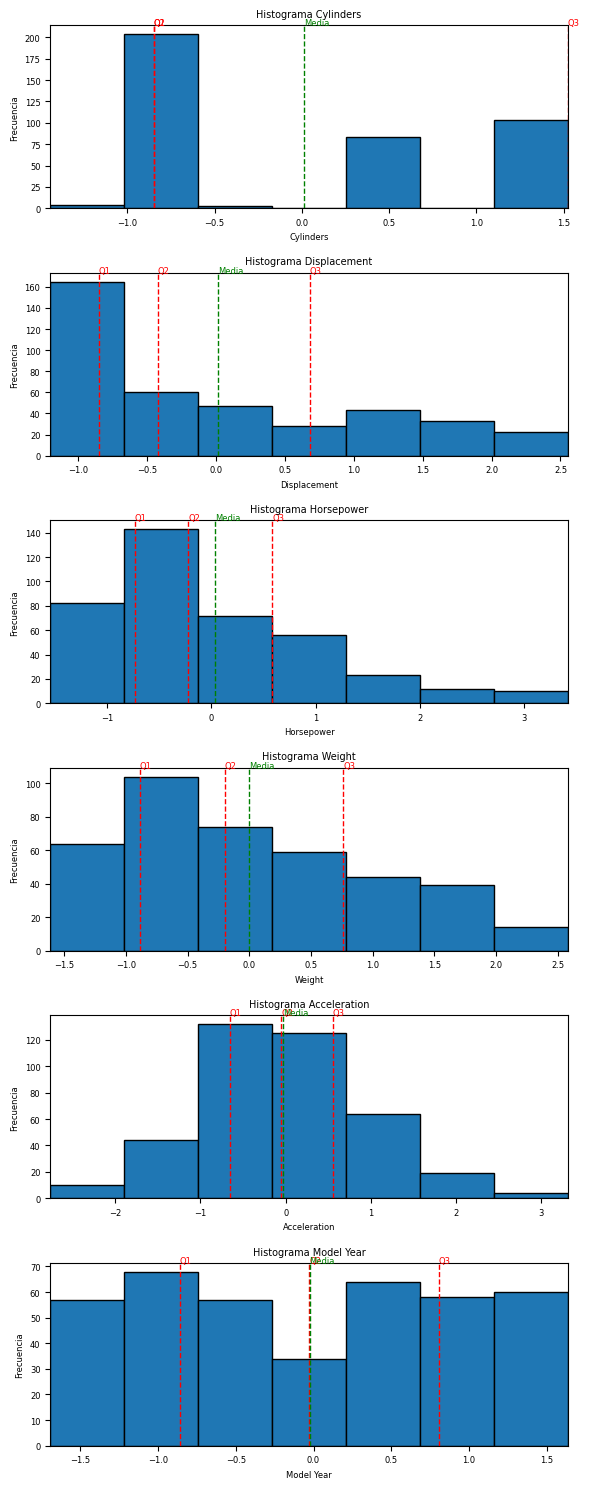

In [18]:
# Genera los histogramas de las características del modelo. Se puede observar que la media=0 (línea vertical verde)
variables=['Cylinders','Displacement','Horsepower','Weight',   'Acceleration', 'Model Year']
plot_histograms(df_scaled, variables,6,15)

### **4.4 Modelo Red Neuronal**  

El código siguiente implementa un modelo de red neuronal utilizando **tensorflow y keras**. El desarrollo de un modelo de aprendizaje automático se puede llevar a cabo una ves que se ha realizado la **transformación One Hot Encoding**, la selección de los datos de **entrenamiento y prueba** así como la **normalización** de estos.  
Una red neuronal se puede desarrollar através de los siguientes pasos:

*  **1. Definición del modelo:**
*  **2. Configiración proceso de aprendizaje**
*  **3. Entrenamiento del modelo**
*  **4. Evaluación del modelo**  
*  **5. Predicción del modelo**

#### **4.4.1 Definición del Modelo (capas red neuronal)**  

Este proceso implica elegir la arquitectura de la red, que incluye el número de capas, el tipo de cada capa y cómo se conectan entre sí. Utilizando la biblioteca Keras de TensorFlow se puede definir utilizando:

**1. Componentes Clave de un Modelo de Red Neuronal**  
*  **Capas de Entrada:** Definen la forma de los datos que se alimentan a la red.
*  **Capas Ocultas:** Realizan la mayor parte del procesamiento. Pueden ser capas densas (fully connected), convolucionales (convolutional), recurrentes (recurrent), etc.
*  **Capa de Salida:** Produce la salida del modelo. Su diseño depende del tipo de problema (regresión, clasificación, etc.).  

**2. Tipos de Capas Comunes**
*  **Capa Densa (Dense Layer):** Conecta todas las neuronas de la capa anterior con todas las neuronas de la capa siguiente.
*  **Capa de Activación (Activation Layer):** Aplica una función de activación a la salida de la capa anterior (como ReLU, Sigmoid, Softmax).
*  **Capa de Dropout:** Se utiliza para prevenir el sobreajuste al desactivar aleatoriamente una fracción de las neuronas durante el entrenamiento.
*  **Capa Convolucional (Conv2D):** Común en tareas de visión por computadora.
*  **Capa de MaxPooling (MaxPooling2D):** Reduce la dimensionalidad de las características extraídas.


**3. Funciones de activación**
Las funciones de activación son esenciales en las redes neuronales, ya que introducen no linealidades en el modelo, lo que permite aprender patrones complejos en los datos. TensorFlow y Keras proporcionan varias funciones de activación que se pueden usar en diferentes capas de la red neuronal.Algunas de las funciones de activación más comunes en TensorFlow son:

*  **ReLU :** Utilizada comúnmente en capas ocultas por su eficiencia y capacidad para mitigar el problema del desvanecimiento del gradiente.

*  **Sigmoid :** Utilizada generalmente en capas de salida para problemas de clasificación binaria. Su salida está en el rango (0, 1).
*  **Softmax :** Utilizada generalmente en capas de salida para problemas de clasificación. Convierte un vector de valores en un vector de probabilidades, útil para clasificación múltiple.
*  **Tanh :** Puede ser útil en capas ocultas cuando se necesita que la salida esté centrada en cero. Es similar a la sigmoide pero su salida está en el rango (-1, 1).



Para este proyecto se diseña una red neuronal completamente conectada (también conocida como perceptrón multicapa o MLP), diseñada para trabajar con un conjunto de datos que tiene 9 características de entrada. Los componentes clave de la arquitectura son:

*  **Capa de entrada:** tiene una forma de [9], lo que significa que cada muestra del conjunto de datos tiene 9 características.

*  **Primera capa oculta:** capa con 100 neuronas, que usa la función de activación ReLU (Rectified Linear Unit). El número total de parámetros en esta capa es de 10*100 = 1000 (9 entradas + 1 bias multiplicado por 100 neuronas).

*  **Segunda capa oculta:** capa con 100 neuronas, con activación ReLU.
Los parámetros en esta capa son 100 neuronas de la capa anterior conectadas a 100 neuronas de esta capa, lo que da 100*100 = 10,000 parámetros.

*  **Tercera capa oculta:** capa con 50 neuronas, con activación ReLU.
La cantidad de parámetros es 100*50 = 5,000 (100 conexiones de la capa anterior por 50 neuronas en esta capa).

*  **Capa de salida:** capa final tiene 1 neurona, sin función de activación, lo que es adecuado para problemas de regresión, donde el objetivo es predecir un valor continuo. Esta capa tiene 50*1 = 50 parámetros.

En resumen es una red con 3 capas ocultas, activación ReLU y una capa de salida lineal. En total, la red tiene 1000 + 10,000 + 5,000 + 50 = 16,050 parámetros entrenables.

In [19]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

#Construcción red neuronal con 1 capa de entrada y dos capas ocultas


def build_model():
  model = Sequential()        # 9 entrada + 1 = 10 * 10 =100
  model.add(Dense(100, activation='relu', input_shape=[9]))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(50,  activation='relu'))
  model.add(Dense(1))
  return model

model = build_model()      # Definición del modelo
model.summary()            # Resumen configuración del modelo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 100)                 │           1,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,201 (63.29 KB)

 Trainable params: 16,201 (63.29 KB)

 Non-trainable params: 0 (0.00 B)

#### **4.4.2 Configuración Proceso Aprendizaje (model.compile)**

La configuración del proceso de aprendizaje de un modelo en Keras se realiza mediante el método **model.compile()**. Este método es fundamental, ya que define cómo se entrenará el modelo, especificando:

*  **El optimizador** se encarga de actualizar los pesos del modelo basándose en la función de pérdida. Existen varios optimizadores.
     *  **adam:** Un optimizador basado en el método de descenso de gradiente que ajusta la tasa de aprendizaje de manera adaptativa. Es uno de los más utilizados.
     *  **sgd:** El descenso de gradiente estocástico, que puede incluir momentum para mejorar la convergencia.
     *  **rmsprop:** Root Mean Square Propagation es una variante del descenso de gradiente que ajusta la tasa de aprendizaje de forma adaptativa para cada parámetro del modelo. Este optimizador es particularmente útil cuando estás trabajando con redes neuronales profundas, ya que ayuda a mitigar algunos de los problemas de descenso de gradiente estándar, como la oscilación en el gradiente.
     Puedes ajustar el optimizador pasando parámetros adicionales, como la tasa de aprendizaje. Tiene otros parámetros por configurar:
          *  **learning_rate:** Tasa de aprendizaje, controla el tamaño de los pasos que el optimizador da para ajustar los pesos del modelo. Un valor comúnmente utilizado es 0.001, pero puede ajustarse según el problema.
          *  **rho:** Parámetro de descomposición exponencial para calcular las medias cuadráticas móviles de los gradientes. Por defecto, es 0.9.
          *  **momentum (opcional):** Puede ayudar al optimizador a moverse más rápidamente en la dirección de los gradientes, suavizando las oscilaciones.
          *  **epsilon:** Un pequeño valor agregado para mejorar la estabilidad numérica y evitar divisiones por cero. Su valor predeterminado es 1e-7.

*  **Función de pérdida** mide qué tan bien está funcionando el modelo durante el entrenamiento. La elección de la función de pérdida depende del tipo de problema que estás abordando. Existen varias funciones de pérdida.
     *  **mean_squared_error:** Usada para problemas de regresión.
     *  **binary_crossentropy:** Utilizada para problemas de clasificación binaria.
     *  **categorical_crossentropy:** Usada para problemas de clasificación multiclase (cuando las etiquetas son codificadas como vectores de una sola dimensión).  

*  **Métricas** son utilizadas para evaluar el rendimiento del modelo durante el entrenamiento y la validación. Se puede especificar múltiples métricas.
     *  **accuracy:** Proporción de predicciones correctas, utilizada en problemas de clasificación.
     *  **mae:** Error absoluto medio, útil para problemas de regresión.
     *  **mse:** Error cuadrático medio.  

*  **Early Stopping:** Se puede configurar para evitar el sobreajuste. Puedes utilizar el callback de EarlyStopping para detener el entrenamiento cuando la métrica de validación no mejora durante un número de épocas consecutivas.  

     *  **monitor:** parámetro que indica qué métrica se va a monitorear para determinar cuándo detener el entrenamiento('val_loss', 'val_accuracy', entre otras).
     *  **patience:** especifica el número de épocas adicionales que se permitirán sin mejoras antes de detener el entrenamiento (Ej. si patience=10, el entrenamiento se detendrá si la métrica monitoreada no mejora durante 10 épocas consecutivas).
     *  **min_delta:** Es el cambio mínimo requerido en la métrica monitoreada para ser considerado una mejora. Si el cambio es menor a min_delta, no se considerará como una mejora.
     *  **restore_best_weights:** Si se establece como True, el modelo restaurará los pesos de la mejor época al finalizar el entrenamiento, lo que puede ser útil si el modelo se detiene en una época peor que la mejor.




In [20]:

optimizer = tf.keras.optimizers.RMSprop(0.001)  # Ratio de aprendizaje=0.001

model = build_model()
model.compile(loss='mse',                       # Función pérdida= mse
                optimizer=optimizer,
                metrics=['mae', 'mse'])

# callbacks "EarlyStopping" controla no exceder num de epocas (overfiting)
early_stop = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', patience=10)

#### **4.4.3 Entrenamiento del modelo (model.fit)**

El entrenamiento de un modelo en Keras se realiza mediante el método model.fit(). Este método ajusta el modelo a los datos de entrenamiento durante un número especificado de épocas, utilizando un conjunto de datos de entrada y sus correspondientes etiquetas o valores de salida.  Los principales parámetros para ajustarlo son:

*  **x:** datos de entrada para entrenar el modelo
*  **y:** etiquetas o valores de salida correspondientes a los datos de entrada x.
*  **epochs:** Número de veces que el algoritmo verá el conjunto completo de datos. Cada pasada por el conjunto completo de datos se llama una época.
*  **batch_size:** Número de muestras procesadas antes de que el modelo actualice sus pesos. Un valor común es 32, aunque se puede ajustar según las necesidades y el tamaño del dataset.
*  **validation_data:** Un conjunto de datos que no se utiliza para entrenar el modelo, pero sí para evaluar su rendimiento después de cada época. Puede ser un conjunto separado de datos (X_val, y_val), o puedes usar el parámetro validation_split para reservar una fracción del conjunto de entrenamiento para la validación.
*  **callbacks:** Una lista de objetos Callback (como EarlyStopping, ModelCheckpoint) que permiten personalizar el proceso de entrenamiento, como detenerlo temprano si no mejora la pérdida o guardar el mejor modelo durante el entrenamiento.
*  **shuffle:** Si es True, los datos se barajan antes de cada época. Es una práctica común barajar los datos de entrenamiento para evitar que el modelo aprenda un patrón no deseado relacionado con el orden de los datos.

In [21]:
# Objeto history devuelve el método fit() contiene información sobre el entrenamiento en cada época, incluyendo:
# Pérdida y métricas en los datos de entrenamiento, así como Pérdida y métricas en los datos de validación.
Epocas=200

history = model.fit(X_train_scaled , y_train, epochs=Epocas, # 20% de los datos de entrenamiento para utilizarlos como datos de validación.
                    validation_split = 0.2, verbose=1,       # verbose=1 despliega información loss, mae, mse
                    callbacks=[early_stop] )

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - loss: 583.2804 - mae: 22.7563 - mse: 583.2804 - val_loss: 469.1629 - val_mae: 20.2746 - val_mse: 469.1629
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 430.9480 - mae: 18.9013 - mse: 430.9480 - val_loss: 289.2121 - val_mae: 15.3407 - val_mse: 289.2121
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 260.1503 - mae: 13.9650 - mse: 260.1503 - val_loss: 121.3495 - val_mae: 9.5858 - val_mse: 121.3495
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 104.3771 - mae: 8.7576 - mse: 104.3771 - val_loss: 39.3473 - val_mae: 5.0999 - val_mse: 39.3473
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 38.2793 - mae: 5.0338 - mse: 38.2793 - val_loss: 23.8077 - val_mae: 3.9299 - val_mse: 23.8077
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 20.5665 - mae: 3.5945 - mse: 20.5665 - val_loss: 19.2536 - val_mae: 3.6095 - val_mse: 19.2536
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 17.3366 - mae:

In [22]:
## Crea df del hitorial de entrenamiento
df_history = pd.DataFrame(history.history)
df_history['epoch'] = history.epoch
df_history.tail(3)

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
86,6.098,1.711,6.098,7.768,2.191,7.768,86
87,6.432,1.739,6.432,6.951,2.142,6.951,87
88,5.720,1.675,5.720,7.017,2.168,7.017,88


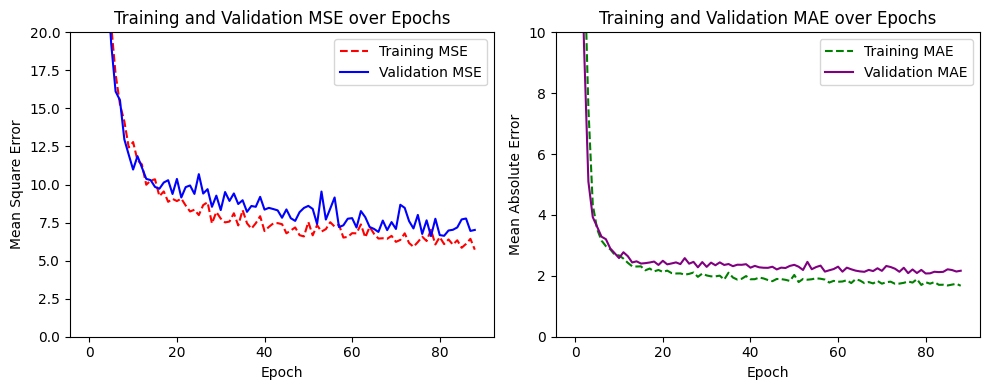

In [24]:
import matplotlib.pyplot as plt
## Genera función para graficar el MSE y el MAE en función de las epocas

def plot_training_history(df_history):
    # Crear dos subplots, uno para MSE y otro para MAE
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))  # 1 fila, 2 columnas

    # Gráfica del MSE (lado izquierdo)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Mean Square Error')
    ax1.plot(df_history['epoch'], df_history['mse'], 'r--', label='Training MSE')
    ax1.plot(df_history['epoch'], df_history['val_mse'], 'b', label='Validation MSE')
    ax1.set_ylim([0, 20])
    ax1.legend(loc='upper right')
    ax1.set_title('Training and Validation MSE over Epochs')

    # Gráfica del MAE (lado derecho)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Mean Absolute Error')
    ax2.plot(df_history['epoch'], df_history['mae'], 'g--', label='Training MAE')
    ax2.plot(df_history['epoch'], df_history['val_mae'], 'purple', label='Validation MAE')
    ax2.set_ylim([0, 10])
    ax2.legend(loc='upper right')
    ax2.set_title('Training and Validation MAE over Epochs')

    plt.tight_layout()  # Ajusta el layout para evitar solapamientos
    plt.show()

# Llamada a la función con el DataFrame df_history
plot_training_history(df_history)

#### **4.4.4 Evaluación del modelo (model.evaluate)**

La evaluación de un modelo en Keras se realiza con el método **model.evaluate()**, que se utiliza para obtener las métricas de rendimiento del modelo sobre un conjunto de datos de prueba o validación, generalmente después de que el modelo ha sido entrenado. Este método devuelve los valores de las métricas especificadas durante la compilación del modelo, como la pérdida (loss) y las métricas adicionales que hayas definido, como la precisión (accuracy), el error absoluto medio (mae), entre otras.  

*  **x:** Datos de entrada sobre los cuales se va a evaluar el modelo. Generalmente, se utiliza el conjunto de datos de prueba X_test.
*  **y:** Etiquetas o valores reales correspondientes a los datos de entrada x. En problemas de clasificación, y son las clases verdaderas, y en problemas de regresión, son los valores reales que queremos predecir.
*  **batch_size:** Número de muestras por lote que se pasarán para la evaluación. Si no se especifica, se utiliza el valor por defecto.

*  **verbose:**
     *  **0:** No muestra salida de la evaluación.
     *  **1:** Muestra el progreso de la evaluación.
     *  **sample_weight:** Pesos opcionales de las muestras para darle más importancia a ciertos ejemplos.
     *  **return_dict:** Si es True, devuelve un diccionario con los nombres de las métricas como claves y sus valores correspondientes.

In [25]:
loss_NN, mse_NN, mae_NN = model.evaluate(X_test_scaled , y_test, batch_size=None, verbose=1, sample_weight=None, return_dict=False)

print("\n*** Resultado del modelo Red Neuronal 3 capas y función Pérdida=mse ***\n")
print("\n      Error Absoluto Medio (MAE) X_test  : {:5.2f} MPG".format(mae_NN))
print("      Error Cuadrático Medio (MSE) X_test: {:5.2f} MPG".format(mse_NN))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0178 - mae: 1.7845 - mse: 5.0178  

*** Resultado del modelo Red Neuronal 3 capas y función Pérdida=mse ***


      Error Absoluto Medio (MAE) X_test  :  4.77 MPG
      Error Cuadrático Medio (MSE) X_test:  1.75 MPG


#### **4.4.5 Predicción del modelo (model.predict)**  

La predicción de un modelo en Keras se realiza con el método **model.predict()**, que permite usar el modelo ya entrenado para realizar predicciones sobre nuevos datos. Este método es útil cuando quieres predecir valores de salida (ya sea clasificación o regresión) para un conjunto de datos de prueba, validación o cualquier dato no visto por el modelo durante el entrenamiento.  Parámetros de entrenamiento:  

*  **x:** Los datos de entrada sobre los que se harán las predicciones. Deben tener el mismo formato que los datos utilizados para entrenar el modelo.
*  **batch_size:** El número de muestras que se pasan al modelo a la vez para predecir. Si no se especifica, se usará un valor por defecto que suele ser eficiente para el hardware disponible.
*  **verbose:**
   *  **0:** No muestra salida.
   *  **1:** Muestra el progreso de las predicciones.
   *  **steps:** Número de lotes de muestras que se pasarán al modelo. Si steps no está definido y los datos de entrada son un array NumPy o un DataFrame de pandas, el número de pasos será len(x) // batch_size.
   *  **callbacks:** Una lista de callbacks opcionales para aplicar durante la predicción.

In [26]:
# Predicciones con datos prueba
predict = model.predict(X_test_scaled).ravel()  # .ravel Convierte las predicciones a una dimensión

# DataFrame con las predicciones y los valores reales
df_est_mod = pd.DataFrame({'MPG_Real': y_test, 'MPG_Estimated': predict})

# Seleccionar las columnas específicas de X_test
selected_columns = X_test[['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year']]

# Concatenar las columnas seleccionadas a df_est_mod
df_est_mod  = pd.concat([df_est_mod, selected_columns], axis=1)
df_est_mod

df_est_mod.head(5)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


,MPG_Real,MPG_Estimated,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
198,33.000,32.326,4,91.000,53.000,1795.000,17.400,76
396,28.000,28.148,4,120.000,79.000,2625.000,18.600,82
33,19.000,21.155,6,232.000,100.000,2634.000,13.000,71
208,13.000,15.137,8,318.000,150.000,3940.000,13.200,76
93,14.000,13.513,8,318.000,150.000,4237.000,14.500,73


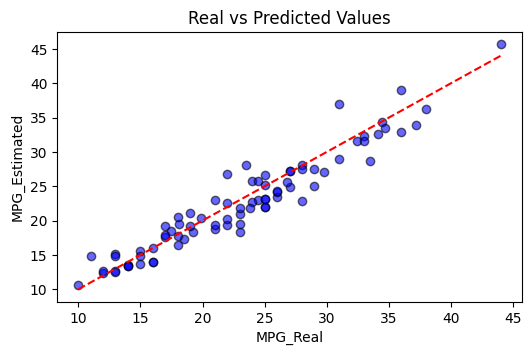

In [27]:
# Gráfica comparativa entre valores reales y predichos
plt.figure(figsize=(6, 3.5))
plt.scatter(df_est_mod['MPG_Real'], df_est_mod['MPG_Estimated'], color='blue', edgecolor='k', alpha=0.6)
plt.xlabel('MPG_Real')
plt.ylabel('MPG_Estimated')
plt.title('Real vs Predicted Values')
plt.plot([df_est_mod['MPG_Real'].min(), df_est_mod['MPG_Real'].max()],
         [df_est_mod['MPG_Real'].min(), df_est_mod['MPG_Real'].max()], color='red', linestyle='--')  # Línea ideal
plt.show()


### **4.5 Modelo Regresión Múltiple**  

El código siguiente implementa un modelo de Regresión Lineal Múltiple para estimar el consumo de combustible utilizando **scikit-learn**. Los pasos para generar un modelo de regresión final múltiple son:

*  **1. Ajuste del modelo (model_LR.fit())**
*  **2. Obtención de los coeficientes e intersección**
*  **3. Despliegue de la ecuación de la regresión**
*  **4. Predicción de valores (model_LR.predict())**
*  **5. Cálculo de métricas de error**


#### **4.5.1. Creación y Ajuste del modelo (model_LR.fit())**
Para la creación y ajuste de un modelo de regresión se requiere crear una una instancia del modelo de regresión lineal (LinearRegression()) y posteriormente se ajusta el modelo a los datos de entrenamiento X_train_scaled y y_train con **model_LR.fit()**. Esto hace que el modelo aprenda los coeficientes de la ecuación lineal.

Los parámetros clave de LinearRegression en scikit-learn son:

**CREACIóN DEL MODELO**

**model_LR = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=-1, positive=True)**

*  **fit_intercept=** True: Ajustará una intersección (ordenada al origen) al modelo, lo que significa que permitirá que la línea de regresión tenga un valor distinto de 0 cuando todas las variables independientes sean 0.
*  **copy_X=** True: Garantiza que los datos originales no sean sobrescritos.
*  **n_jobs=-1:** Utiliza todas las CPUs disponibles para hacer más eficiente el ajuste del modelo en caso de que los datos sean grandes.
*  **positive=True:** Obligará a los coeficientes a ser no negativos, lo cual puede ser útil en algunos casos donde las variables solo tienen sentido físico con coeficientes positivos.

**model_LR.fit(X_train_scaled, y_train)**

Este método recibe los siguientes parámetros principales:

*  **X_train_scaled:** conjunto de datos de entrada (o características) que han sido escalados o normalizados para mejorar el rendimiento del modelo.
*  **y_train:** conjunto de valores objetivo (o etiquetas) asociados a los datos de entrenamiento. Este es el valor que el modelo intentará predecir con base en las características de entrada.


In [28]:
## Exploración de datos: Matriz de correlación
df_numeric=df.select_dtypes(include=["float","int64"])    ##Eliminar las columnas NO numéricas
my_corr = df_numeric.corr()
my_corr.head(10)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
MPG,1.000,-0.775,-0.804,-0.771,-0.832,0.420,0.579,0.563
Cylinders,-0.775,1.000,0.951,0.839,0.896,-0.505,-0.349,-0.563
Displacement,-0.804,0.951,1.000,0.894,0.933,-0.544,-0.370,-0.609
Horsepower,-0.771,0.839,0.894,1.000,0.861,-0.684,-0.412,-0.454
Weight,-0.832,0.896,0.933,0.861,1.000,-0.417,-0.307,-0.581
Acceleration,0.420,-0.505,-0.544,-0.684,-0.417,1.000,0.288,0.206
Model Year,0.579,-0.349,-0.370,-0.412,-0.307,0.288,1.000,0.181
Origin,0.563,-0.563,-0.609,-0.454,-0.581,0.206,0.181,1.000


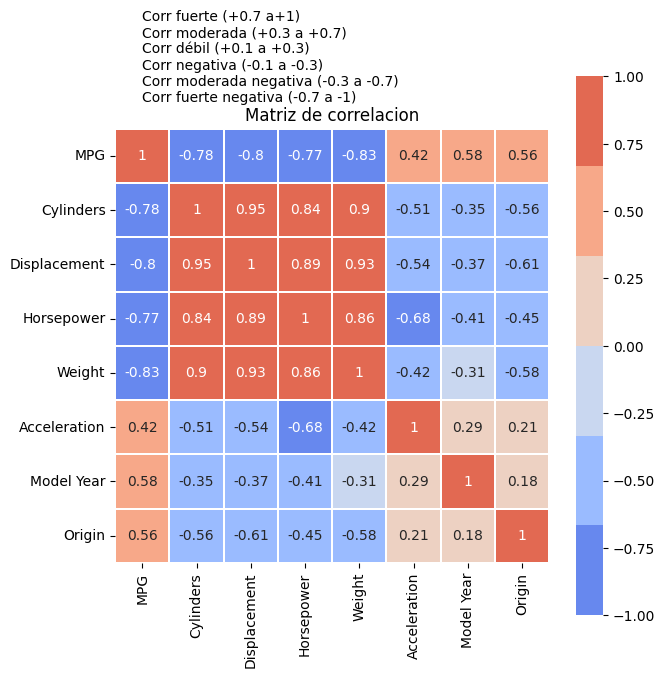

In [29]:
my_corr =  df_numeric.corr()

plt.figure(figsize=(7,7))
sns.heatmap(my_corr, annot=True, square=True,
            cmap=sns.color_palette("coolwarm"),
            vmax=1,
            vmin=-1,
           linewidths=0.3)
plt.title("Matriz de correlacion")
plt.text(0.5,-0.5, "Corr fuerte (+0.7 a+1)\nCorr moderada (+0.3 a +0.7)\nCorr débil (+0.1 a +0.3)\nCorr negativa (-0.1 a -0.3)\nCorr moderada negativa (-0.3 a -0.7)\nCorr fuerte negativa (-0.7 a -1)")
plt.show()

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Crea el modelo de regresión lineal
model_LR = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=-1, positive=True)

# Ajusta el modelo con los datos de entrenamiento
model_LR.fit(X_train_scaled, y_train)

LinearRegression(n_jobs=-1, positive=True)

#### **4.5.2. Obtención de los coeficientes e intersección**
Después de ajustar el modelo, se obtienen los coeficientes y la intersección:

*  **model_LR.coef_:** Devuelve los coeficientes de la regresión lineal, es decir, las pendientes para cada variable.

*  **model_LR.intercept_:** Devuelve la intersección, el valor de y cuando todas las variables independientes son 0.

In [31]:
# Obtiene los coeficientes y los nombres de las características
coefficients = model_LR.coef_
feature_names = X.columns

# Crea el DataFrame con los nombres de las características y los coeficientes
df_coefficients = pd.DataFrame({
    'Caracteristicas': feature_names,
    'Coeficientes': coefficients
})

print("Ordenada al origen del modelo :",model_LR.intercept_)
df_coefficients

Ordenada al origen del modelo : 23.60817610062894


,Caracteristicas,Coeficientes
0,Cylinders,0.000
1,Displacement,0.000
2,Horsepower,0.000
3,Weight,0.000
4,Acceleration,1.146
5,Model Year,3.683
6,USA,0.000
7,Europe,2.684
8,Japan,3.227


#### **4.5.2. Despliegue de la ecuación de la regresión**
El código construye y muestra la ecuación de la regresión lineal múltiple utilizando los coeficientes e intersección. Si X_train_scaled es un DataFrame de pandas, los nombres de las columnas se extraen de allí; si es un array de NumPy, se generan nombres genéricos como X1, X2, etc.

In [32]:
# Despliega ecuación de regresión con los coeficientes originales (sin normalización)
# Calcula la media y la desviación estándar de las características originales
means = X_train.mean()
stds = X_train.std()

# Coeficientes del modelo ajustado
coefficients = model_LR.coef_
intercept = model_LR.intercept_

# Revierte la normalización de los coeficientes
original_coefficients = coefficients * stds.values
original_intercept = intercept - sum((means * original_coefficients))

# Despliega la ecuación de la regresión lineal en la escala original
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'X{i+1}' for i in range(X_train.shape[1])]

print("Ecuación de la regresión lineal múltiple (coeficientes originales):")
equation = "y = {:.4f}".format(original_intercept)
for coef, feature in zip(original_coefficients, feature_names):
    equation += " + {:.4f}*{}".format(coef, feature)

print(equation)

Ecuación de la regresión lineal múltiple (coeficientes originales):
y = -1036.1956 + 0.0000*Cylinders + 0.0000*Displacement + 0.0000*Horsepower + 0.0000*Weight + 3.1673*Acceleration + 13.2689*Model Year + 0.0000*USA + 1.0239*Europe + 1.3106*Japan


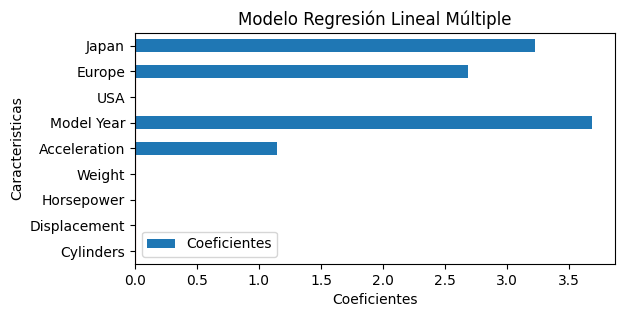

In [33]:
df_coefficients.plot.barh(x='Caracteristicas', y='Coeficientes', figsize=(8, 3))

plt.title("Modelo Regresión Lineal Múltiple")
plt.axvline(x=0, color='r')
plt.xlabel('Coeficientes')
plt.ylabel('Caracteristicas')
plt.subplots_adjust(left=0.3)

In [34]:
# Evalua el modelo en los datos de prueba
y_pred_LR = model_LR.predict(X_test_scaled)

# Calcula el Error Cuadrático Medio (MSE) y el Error Absoluto Medio (MAE)
mse = mean_squared_error(y_test, y_pred_LR)
mae = mean_absolute_error(y_test, y_pred_LR)
r2_score = model_LR.score(X_test_scaled, y_test)

# Muestra el MSE, MAE y R^2
print("\n Resultados Validación Modelo Regresión Lineal Multiple:")
print("\n   Error Cuadrático Medio (MSE): {:5.2f}".format(mse))
print("   Error Absoluto Medio (MAE)  : {:5.2f}".format(mae))
print("   R^2 score en el conjunto de prueba: {:5.2f}".format(r2_score))


 Resultados Validación Modelo Regresión Lineal Multiple:

   Error Cuadrático Medio (MSE): 19.73
   Error Absoluto Medio (MAE)  :  3.60
   R^2 score en el conjunto de prueba:  0.63


#### **4.5.4. Predicción de valores (model_LR.predict())**
Después de ajustar el modelo, se puede realizar las predicciones sobre los datos de prueba X_test_scaled con **model_LR.predict()**. Esto genera un array con los valores predichos y_pred_LR, que luego se comparan con los valores reales y_test.

In [35]:
# Evaluar el modelo en los datos de prueba
y_pred_LR = model_LR.predict(X_test_scaled)


#### **4.5.5. Cálculo de métricas de error**
El código utiliza dos métricas clave para evaluar el rendimiento del modelo:

Error Cuadrático Medio (MSE): Evalúa el promedio de los cuadrados de los errores, es decir, la diferencia cuadrada entre los valores predichos y los valores reales.
Error Absoluto Medio (MAE): Evalúa el promedio de las diferencias absolutas entre los valores predichos y los valores reales.
Ambas métricas se calculan utilizando:

In [36]:
# Calcular el Error Cuadrático Medio (MSE) y el Error Absoluto Medio (MAE)
mse_LR = mean_squared_error(y_test, y_pred_LR)
mae_LR = mean_absolute_error(y_test, y_pred_LR)

# Mostrar el MSE, MAE y R^2
print("\n Resultados Validación Modelo Regresión Lineal Multiple:")
print("\nError Cuadrático Medio (MSE): {:5.2f}".format(mse_LR))
print("Error Absoluto Medio (MAE): {:5.2f}".format(mae_LR))

r2_score = model_LR.score(X_test_scaled, y_test)
print("R^2 score en el conjunto de prueba: {:5.2f}".format(r2_score))


 Resultados Validación Modelo Regresión Lineal Multiple:

Error Cuadrático Medio (MSE): 19.73
Error Absoluto Medio (MAE):  3.60
R^2 score en el conjunto de prueba:  0.63


In [37]:
# Predicciones con datos prueba
predict_LR = model_LR.predict(X_test_scaled).ravel()  # .ravel Convierte las predicciones a una dimensión

# DataFrame con las predicciones y los valores reales
df_est_mod["MPG_Estimated_LR"] = predict_LR

df_est_mod.sample(10)

,MPG_Real,MPG_Estimated,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,MPG_Estimated_LR
116,16.000,14.026,8,400.000,230.000,4278.000,9.500,73,15.002
298,23.000,18.328,8,350.000,125.000,3900.000,17.400,79,24.411
386,25.000,25.133,6,181.000,110.000,2945.000,16.400,82,27.062
225,17.500,18.485,6,250.000,110.000,3520.000,16.400,77,21.952
73,13.000,14.790,8,307.000,130.000,4098.000,14.000,72,15.846
351,34.400,34.281,4,98.000,65.000,2045.000,16.200,81,25.957
172,25.000,26.601,4,90.000,71.000,2223.000,16.500,75,26.984
72,15.000,14.867,8,304.000,150.000,3892.000,12.500,72,15.224
82,23.000,21.002,4,120.000,97.000,2506.000,14.500,72,23.997
70,13.000,12.467,8,400.000,190.000,4422.000,12.500,72,15.224


### **4.6 Comparación de Modelos**

In [38]:

print("\n*** Resultado del modelo Red Neuronal 3 capas y función Pérdida=mse ***\n")
print("   Error Absoluto Medio (MAE) X_test  : {:5.2f} MPG".format(mae_NN))
print("   Error Cuadrático Medio (MSE) X_test: {:5.2f} MPG".format(mse_NN))


print("\n*** Resultados Validación Modelo Regresión Lineal Multiple ***")
print("\n   Error Absoluto Medio (MAE)  : {:5.2f}".format(mae))
print("   Error Cuadrático Medio (MSE): {:5.2f}".format(mse))
print("   R^2 score en el conjunto de prueba: {:5.2f}".format(r2_score))


*** Resultado del modelo Red Neuronal 3 capas y función Pérdida=mse ***

   Error Absoluto Medio (MAE) X_test  :  4.77 MPG
   Error Cuadrático Medio (MSE) X_test:  1.75 MPG

*** Resultados Validación Modelo Regresión Lineal Multiple ***

   Error Absoluto Medio (MAE)  :  3.60
   Error Cuadrático Medio (MSE): 19.73
   R^2 score en el conjunto de prueba:  0.63


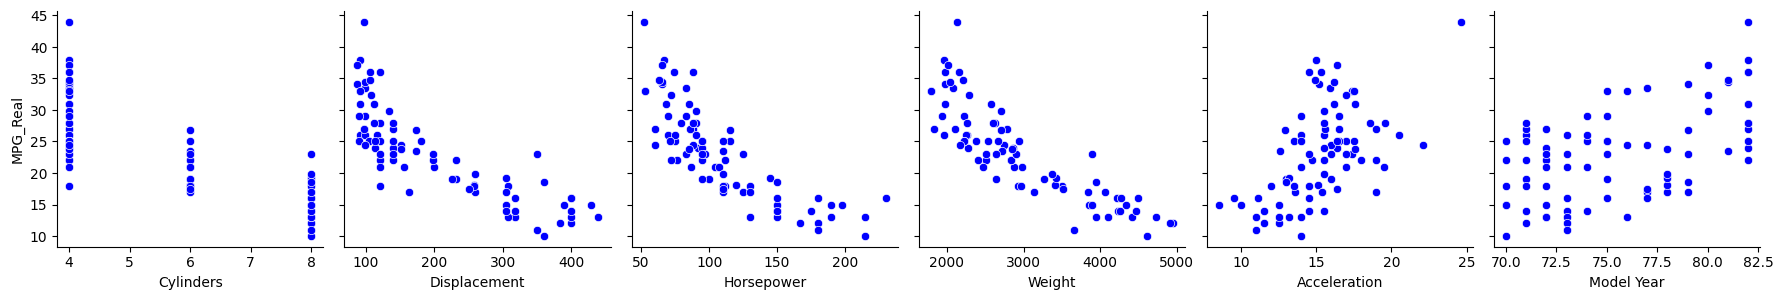

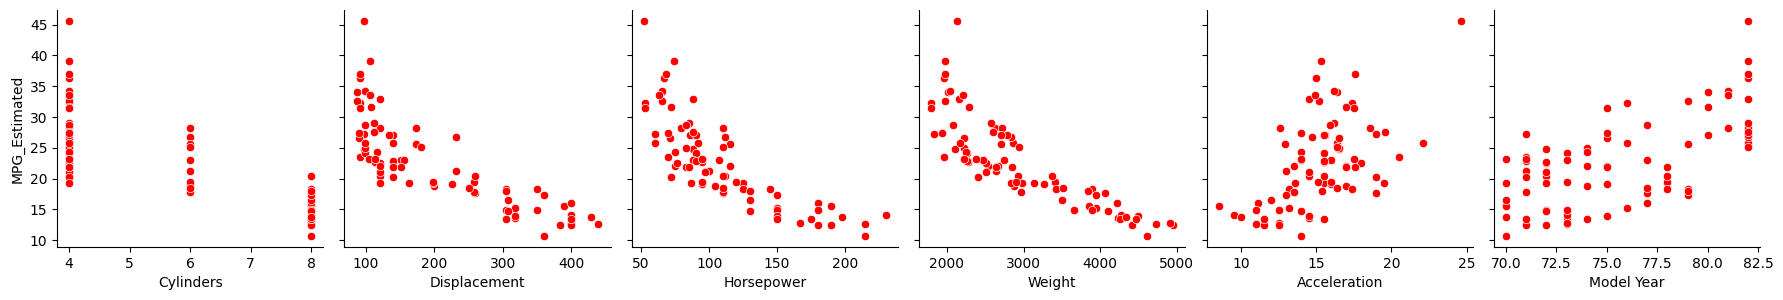

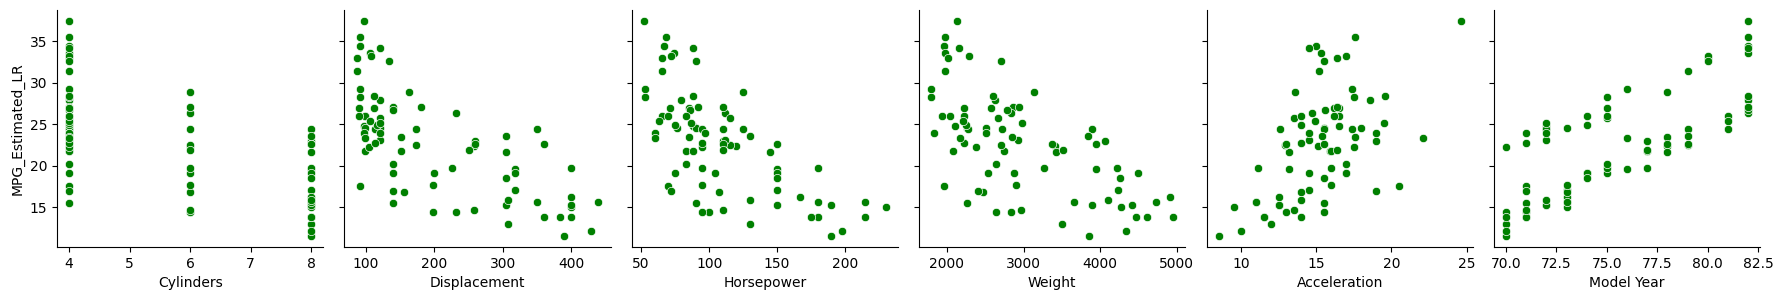

In [39]:
Var_Depen_X=['Cylinders','Displacement','Horsepower','Weight',   'Acceleration', 'Model Year']
Var_Indep_Y =['MPG_Real']
g = sns.pairplot(df_est_mod, x_vars=Var_Depen_X, y_vars=Var_Indep_Y, height=3, plot_kws={'color': 'blue'})

Var_Indep_Y =['MPG_Estimated']
g = sns.pairplot(df_est_mod, x_vars=Var_Depen_X, y_vars=Var_Indep_Y, height=3, plot_kws={'color': 'red'})

Var_Indep_Y =['MPG_Estimated_LR']
g = sns.pairplot(df_est_mod, x_vars=Var_Depen_X, y_vars=Var_Indep_Y, height=3, plot_kws={'color': 'green'})


In [ ]:
column_to_move = df_est_mod.pop('MPG_Estimated_LR')   # Columna Predicción LR
df_est_mod.insert(2, 'MPG_Estimated_LR', column_to_move)  # Inserta col en pos 2

df_est_mod.sample(10)   # Muestra 10 valores aleatorios de las predicciones

,MPG_Real,MPG_Estimated,MPG_Estimated_LR,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
222,17.000,19.659,23.030,8,260.000,110.000,4060.000,19.000,77
380,36.000,35.951,34.218,4,120.000,88.000,2160.000,14.500,82
31,25.000,24.815,22.768,4,113.000,95.000,2228.000,14.000,71
55,27.000,28.195,23.933,4,97.000,60.000,1834.000,19.000,71
341,23.500,27.398,24.464,6,173.000,110.000,2725.000,12.600,81
307,26.800,24.234,22.544,6,173.000,115.000,2700.000,12.900,79
158,16.000,14.996,19.120,8,318.000,150.000,4498.000,14.500,75
152,19.000,19.534,19.742,6,225.000,95.000,3264.000,16.000,75
70,13.000,13.509,15.224,8,400.000,190.000,4422.000,12.500,72
249,19.900,22.673,22.601,8,260.000,110.000,3365.000,15.500,78


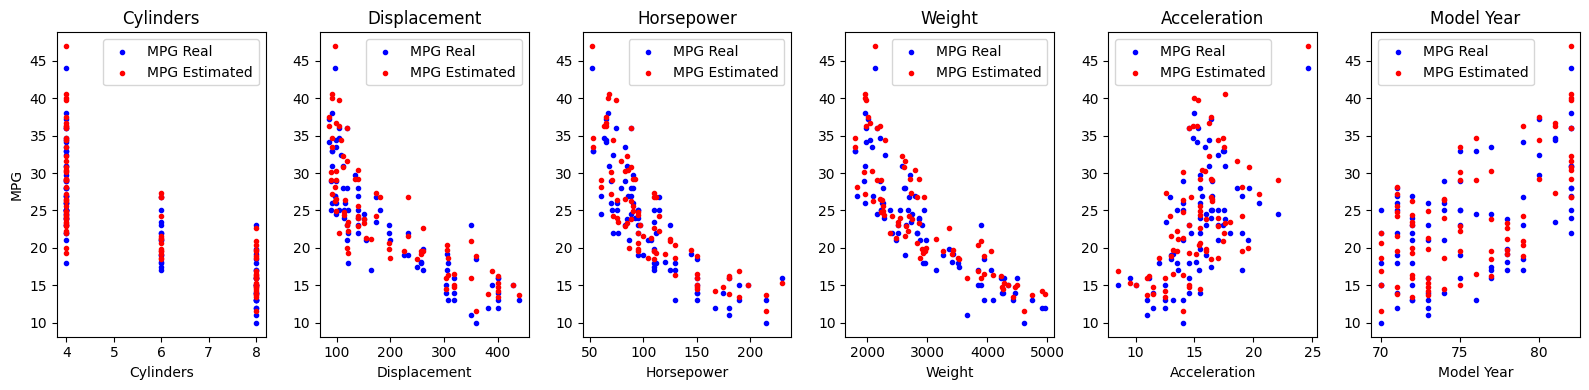

In [ ]:
Var_Depen_X = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year']

fig, axs = plt.subplots(1, len(Var_Depen_X), figsize=(16, 4))  # Crear una figura con 1 fila y N columnas

for i, variable in enumerate(Var_Depen_X):
    axs[i].scatter(df_est_mod[variable], df_est_mod['MPG_Real'], color='blue', label='MPG Real', s=9)           # Puntos MPG Real
    axs[i].scatter(df_est_mod[variable], df_est_mod['MPG_Estimated'], color='red', label='MPG Estimated', s=9)  # Puntos MPG Estimated
    axs[i].set_title(variable)      # Título del subgráfico
    axs[0].set_ylabel('MPG')        # Etiqueta del eje Y
    axs[i].set_xlabel(variable)     # Etiqueta del eje X
    axs[i].legend()                 # Leyenda para cada subgráfico

plt.tight_layout()                  # Ajustar el espacio entre subgráficas
plt.show()                          # Mostrar la figura

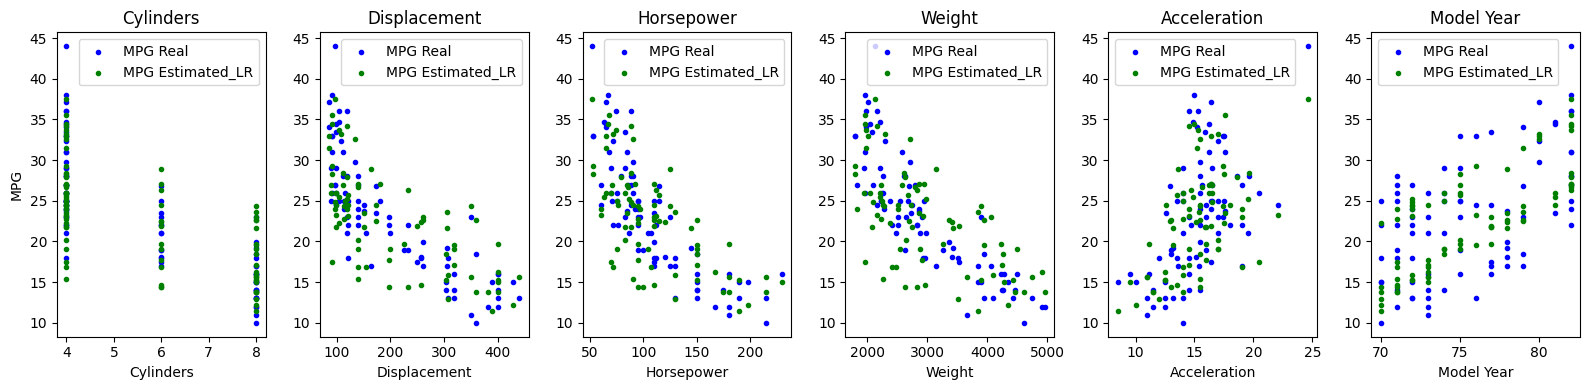

In [ ]:
fig, axs = plt.subplots(1, len(Var_Depen_X), figsize=(16, 4))  # Crear una figura con 1 fila y N columnas

for i, variable in enumerate(Var_Depen_X):
    axs[i].scatter(df_est_mod[variable], df_est_mod['MPG_Real'], color='blue', label='MPG Real', s=9)  # Puntos MPG Real
    axs[i].scatter(df_est_mod[variable], df_est_mod['MPG_Estimated_LR'], color='green', label='MPG Estimated_LR', s=9)  # Puntos MPG Estimated
    axs[i].set_title(variable)  # Título del subgráfico
    axs[0].set_ylabel('MPG')  # Etiqueta del eje Y
    axs[i].set_xlabel(variable)  # Etiqueta del eje X
    axs[i].legend()  # Leyenda para cada subgráfico

plt.tight_layout()  # Ajustar el espacio entre subgráficas
plt.show()  # Mostrar la figura


## **5. Conclusiones**

Los resultados obtenidos de ambos modelos para estimar el consumo de combustible en millas por galón mi/gal utilizando la información del dataset auto-mpg.data, muestran diferencias significativas en su desempeño al predecir el rendimiento de combustible (MPG). ES importante comentar que en este proyecto no busco la optimización de los modelos, se basó únicamente en la explicación de los parámetros e implementación de los dos métodos. No obstante, con base en los resultados podemos comentar que la red neuronal muestra un rendimiento más equilibrado entre MAE y MSE, mientras que la regresión lineal, aunque tiene un MAE menor, presenta un MSE mucho más alto, indicando que sufre de mayores errores en algunas predicciones. El modelo de red neuronal puede ser más adecuado para capturar relaciones no lineales en los datos, mientras que la regresión lineal podría estar limitándose a patrones lineales.


